<a href="https://colab.research.google.com/github/aibak365/randow_to_try/blob/main/SlightChangeAffectOnHaarPsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# (c) 2024 LAiSR-SK
# This code is licensed under the MIT license (see LICENSE.md for details)
from typing import Final, List

import torch
import torch.nn.functional as F
from torch import Tensor
import matplotlib.pyplot as plt
!pip install torchmetrics
import torchvision.transforms as transforms

def haarpsi(
    x: Tensor,
    y: Tensor,
    chromatic: bool = True,
    downsample: bool = True,
) -> Tensor:
    """Computes the ``A Haar Wavelet-Based Perceptual Similarity Index <https://arxiv.org/abs/1607.06140>`__ (HaarPsi).
    Implementation taken from https://github.com/francois-rozet/piqa/blob/master/piqa/haarpsi.py

    :param x: a set of input images. Can be a torch Tensor, List of Pillow Images, or NDArray.
    :param y: a set of input images. Can be a torch Tensor, List of Pillow Images, or NDArray.
    :param chromatic: If True, converts the color space of the input images to 'YIQ'. If False, converts to 'Y'.
    :param downsample: If True, downsamples the input images.

    :returns: the ?? between two images.
    """

    _x: Tensor = x
    _y: Tensor = y

    # Convert the color space of the input images
    convert: Final[ColorConv] = ColorConv(
        "RGB", "YIQ" if chromatic else "Y"
    ).to(_x.device, _x.dtype)

    # Downsample the input images if required
    if downsample:
        _x = F.avg_pool2d(_x, 2, ceil_mode=True)
        _y = F.avg_pool2d(_y, 2, ceil_mode=True)

    # Convert the color space of the input images
    _x = convert(_x)
    _y = convert(_y)

    # Constants for the calculation
    n_kernels: Final[int] = 3
    c: float = 30 / 255**2  # Constant for the gradient similarity calculation
    alpha: Final[float] = 4.2  # Constant for the sigmoid function

    # Separate the Y channel from the input images
    y_x, y_y = _x[:, :1], _y[:, :1]

    # List to store the gradient similarities
    gs: List[Tensor] = []

    # Loop over the number of kernels
    for j in range(1, n_kernels + 1):
        kernel_size: Final[int] = int(2**j)  # Size of the kernel

        # Calculate the Haar wavelet kernel
        haar_kernel: Final[Tensor] = torch.outer(
            torch.ones(kernel_size) / kernel_size,
            torch.tensor([1.0, -1.0]).repeat_interleave(kernel_size // 2),
        )

        # Apply the gradient to the Haar wavelet kernel
        kernel: Tensor = gradient_kernel(haar_kernel).to(_x.device)

        # Apply the Haar filter (gradient)
        pad: Final[int] = kernel_size // 2
        g_x: Final[Tensor] = channel_conv(y_x, kernel, padding=pad)[
            ..., 1:, 1:
        ].abs()
        g_y: Final[Tensor] = channel_conv(y_y, kernel, padding=pad)[
            ..., 1:, 1:
        ].abs()

        if j < n_kernels:
            gs.append((2 * g_x * g_y + c) / (g_x**2 + g_y**2 + c))
        else:
            gs.append(g_x)
            gs.append(g_y)

    # Calculate the local similarities
    ls: Tensor = torch.stack(gs[:-2], dim=-1).mean(dim=-1)

    # Calculate the weights
    w: Tensor = torch.maximum(gs[-2], gs[-1])

    # If the input images have 3 channels (RGB)
    if _x.shape[1] == 3:
        # Separate the IQ channels from the input images
        iq_x, iq_y = _x[:, 1:], _y[:, 1:]

        # Apply the mean filter to the IQ channels
        m_x: Final[Tensor] = F.avg_pool2d(iq_x, 2, stride=1, padding=1)[
            ..., 1:, 1:
        ].abs()
        m_y: Final[Tensor] = F.avg_pool2d(iq_y, 2, stride=1, padding=1)[
            ..., 1:, 1:
        ].abs()

        # Calculate the chromatic similarities
        cs: Final[Tensor] = (2 * m_x * m_y + c) / (m_x**2 + m_y**2 + c)

        # Calculate the local similarities
        ls = torch.cat((ls, cs.mean(dim=1, keepdim=True)), dim=1)

        w = torch.cat((w, w.mean(dim=1, keepdim=True)), dim=1)

    hs: Final[Tensor] = torch.sigmoid(ls * alpha)

    hpsi: Final[Tensor] = (hs * w).sum(dim=(-1, -2, -3)) / w.sum(
        dim=(-1, -2, -3)
    )
    hpsi_l: Final[Tensor] = (torch.logit(hpsi) / alpha) ** 2

    return hpsi_l.detach()

# Image 1: A simple gradient image (with 3 channels)
image1 = torch.linspace(0, 1, steps=224*224).reshape(1, 224, 224).repeat(1,3,1,1)

# Image 2: A slightly shifted version of Image 1
image2 = torch.roll(image1, shifts=1, dims=2) # Shift along a spatial dimension

haarpsi(image1, image2)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

tensor([0.8944])

In [15]:
from PIL import Image
def tensor_to_image(tensor):
    """
    Converts a tensor representing an image to a PIL image object.

    Args:
        tensor: A tensor with shape (C, H, W) representing an image.
                C - number of channels (usually 3 for RGB)
                H - height of the image
                W - width of the image

    Returns:
        A PIL image object that can be displayed or saved.
    """
    if tensor.ndim == 4:
        tensor = tensor.squeeze(0)  # Remove the batch dimension if present

    # If the tensor has only 1 channel, remove the channel dimension
    if tensor.size(0) == 1:
        tensor = tensor.squeeze(0)

    # Clip values between 0 and 1 (assuming they are normalized)
    tensor = tensor.clamp(0, 1)

    # Convert the tensor to a NumPy array
    tensor = tensor.cpu().detach().numpy()

    # Convert the NumPy array to a uint8 array (uint8 for representing pixel values 0-255)
    image_array = (tensor * 255).astype(np.uint8)

    # Create a PIL image from the array
    return Image.fromarray(image_array)


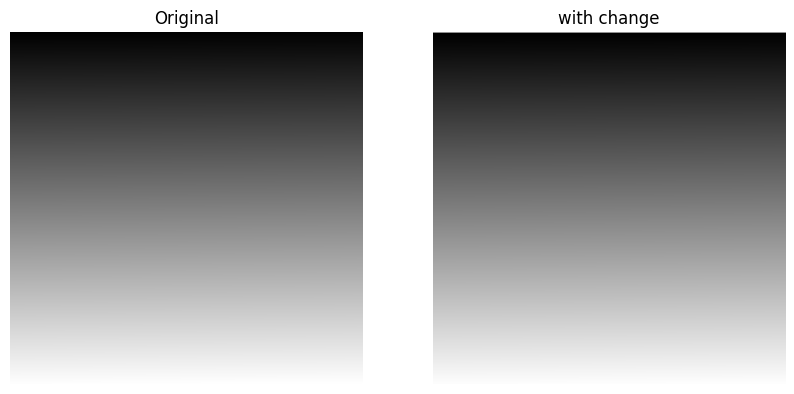

In [16]:

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
# Transpose the tensor to move the channel dimension to the last position, and select the first image from the batch
plt.imshow(image1[0].permute(1, 2, 0)) # Select the first image in the batch
plt.title('Original')
plt.axis('off')  # Hide axes
plt.subplot(1, 2, 2)
# Transpose the tensor to move the channel dimension to the last position, and select the first image from the batch
plt.imshow(image2[0].permute(1, 2, 0)) # Select the first image in the batch
plt.title('with change')
plt.axis('off')  # Hide axes
plt.show()

In [24]:
from urllib.request import urlretrieve
url = "https://images.ctfassets.net/h6goo9gw1hh6/2QZf9aXx4UIiuCEDJ4fqQn/1c223d3e186fd7c9cf443b79c8a3bf92/meme_minutes_COVER.jpg?w=800&h=800&fl=progressive&q=70&fm=jpg"
filename = "cat.jpg"
urlretrieve(url, filename)

img = Image.open(filename)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((1024,1024))
])
# Define x_original
x_original = transform(img).unsqueeze(0) # Add batch dimension

x_edited = transform(img).unsqueeze(0) # Add batch dimension

# Add slight Gaussian noise (humanly imperceptible)
noise = torch.randn(x_edited.shape) * 0.07
x_edited += noise

# Apply subtle color shift (barely noticeable)
x_edited[:, 0] += 0.02  # Increase red channel slightly

# Clamp the values to be between 0 and 1
x_edited = torch.clamp(x_edited, 0, 1)  # Ensure pixel values are within [0, 1]

print(haarpsi(x_original, x_edited))
print(haarpsi(x_original, x_original))

tensor([0.7215])
tensor([1.0000])


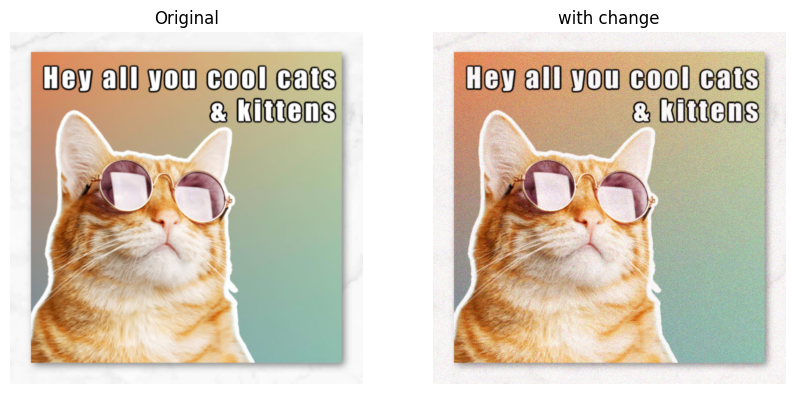

In [23]:
# Display the images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
# Transpose the tensor to move the channel dimension to the last position, and select the first image from the batch
plt.imshow(x_original[0].permute(1, 2, 0)) # Select the first image in the batch
plt.title('Original')
plt.axis('off')  # Hide axes
plt.subplot(1, 2, 2)
# Transpose the tensor to move the channel dimension to the last position, and select the first image from the batch
plt.imshow(x_edited[0].permute(1, 2, 0)) # Select the first image in the batch
plt.title('with change')
plt.axis('off')  # Hide axes
plt.show()

In [2]:
# (c) 2024 LAiSR-SK
# This code is licensed under the MIT license (see LICENSE.md for details)
"""Convolving transforms for torch Tensors."""

from typing import Dict, Final, Optional, Tuple

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Module


def color_conv(
    x: Tensor,
    weight: Tensor,
    bias: Optional[Tensor] = None,
) -> Tensor:
    """To get color convolution of :math:`x` with the kernel `weight`.

    :param x: A tensor, :math:`(N, C, *)`.
    :param weight: A weight kernel, :math:`(C', C)`.
    :param bias: A bias vector, :math:`(C',)`.

    :return color convolution
    """

    return F.linear(x.movedim(1, -1), weight, bias).movedim(-1, 1)


RGB_TO_YIQ: Final[Tensor] = torch.tensor(
    [
        [0.299, 0.587, 0.114],
        [0.5969, -0.2746, -0.3213],
        [0.2115, -0.5227, 0.3112],
    ]
)

RGB_TO_LHM: Final[Tensor] = torch.tensor(
    [
        [0.2989, 0.5870, 0.1140],
        [0.3, 0.04, -0.35],
        [0.34, -0.6, 0.17],
    ]
)

RGB_TO_LMN: Final[Tensor] = torch.tensor(
    [
        [0.06, 0.63, 0.27],
        [0.30, 0.04, -0.35],
        [0.34, -0.6, 0.17],
    ]
)
_WEIGHTS: Dict[Tuple[str, str], Tensor] = {
    ("RGB", "YIQ"): RGB_TO_YIQ,  # HaarPSI
    ("RGB", "Y"): RGB_TO_YIQ[:1],  # GMSD
    ("RGB", "LHM"): RGB_TO_LHM,  # MDSI
    ("RGB", "LMN"): RGB_TO_LMN,  # VSI
    ("RGB", "L"): RGB_TO_LMN[:1],  # VSI
}


class ColorConv(Module):
    """To get Color convolution module.

    :param src: The source color space (e.g. `'RGB'`).
    :param dst: The destination color space (e.g. `'YIQ'`).

    :return Color convolution module.
    """

    def __init__(self, src: str, dst: str):
        super().__init__()

        assert (src, dst) in _WEIGHTS, f"Unknown {src} to {dst} conversion"

        self.register_buffer("weight", _WEIGHTS[(src, dst)])

    def forward(self, x: Tensor) -> Tensor:
        return color_conv(x, self.weight)


def channel_conv(
    x: Tensor,
    kernel: Tensor,
    padding: int = 0,
) -> Tensor:
    """To get the channel-wise convolution of :math:`x` with the kernel `kernel`.

    :param x: A tensor, :math:`(N, C, *)`.
    :param kernel: A kernel, :math:`(C', 1, *)`.
    :param padding: The implicit paddings on both sides of the input dimensions.

    :return the channel-wise convolution
    """

    D = kernel.dim() - 2
    assert D <= 3, "PyTorch only supports 1D, 2D or 3D convolutions."

    if D == 3:
        return F.conv3d(x, kernel, padding=padding, groups=x.shape[-4])
    elif D == 2:
        return F.conv2d(x, kernel, padding=padding, groups=x.shape[-3])
    elif D == 1:
        return F.conv1d(x, kernel, padding=padding, groups=x.shape[-2])
    else:
        return F.linear(x, kernel.expand(x.shape[-1]))


def rgb_to_yiq(x: Tensor) -> Tensor:
    """Converts a batch of RGB images to a batch of YIQ images.

    :param x Batch of images with shape (N, 3, H, W) in RGB colour space.

    :returns: Batch of images with shape (N, 3, H, W) in YIQ colour space.
    """
    yiq_weights: Final[Tensor] = torch.tensor(
        [
            [0.299, 0.587, 0.114],
            [0.5959, -0.2746, -0.3213],
            [0.2115, -0.5227, 0.3112],
        ],
        dtype=x.dtype,
        device=x.device,
    ).t()
    return torch.matmul(x.permute(0, 2, 3, 1), yiq_weights).permute(0, 3, 1, 2)


def xyz_to_lab(x: Tensor) -> Tensor:
    """Converts from (CIE) XYZ to (CIE) LAB color space.

    :param x: An input tensor.

    :returns: The tensor resulting from the conversion from (CIE) XYZ to (CIE) LAB color space.
    """
    illuminants: Tensor = torch.tensor([0.964212, 1.0, 0.825188])  # D50
    delta: float = 6 / 29

    x = color_conv(x, torch.diag(illuminants.to(x)))
    x = torch.where(
        x > delta**3,
        x ** (1 / 3),
        x / (3 * delta**2) + 4 / 29,
    )

    weight: Tensor = torch.tensor(
        [
            [0.0, 116.0, 0.0],
            [500.0, -500.0, 0.0],
            [0.0, 200.0, -200.0],
        ]
    )

    bias: Tensor = torch.tensor([-16.0, 0.0, 0.0])

    return color_conv(x, weight.to(x), bias.to(x))


def rgb_to_xyz(x: Tensor, value_range: float = 1.0) -> Tensor:
    """Converts from sRGB to (CIE) XYZ <https://wikipedia.org/wiki/SRGB>_.

    :param x: a tensor
    :param value_range: The value range :math:`L` of the inputs (usually 1 or 255).

    :return the results of converting sRGB
    """

    x = x / value_range
    x = torch.where(
        x <= 0.04045,
        x / 12.92,
        ((x + 0.055) / 1.055) ** 2.4,
    )

    weight = torch.tensor(
        [
            [0.4124564, 0.3575761, 0.1804375],
            [0.2126729, 0.7151522, 0.0721750],
            [0.0193339, 0.1191920, 0.9503041],
        ]
    )

    return color_conv(x, weight.to(x))


In [3]:
# (c) 2024 LAiSR-SK
# This code is licensed under the MIT license (see LICENSE.md for details)
"""Gradient transforms for Tensors."""

import torch
from torch import Tensor


def gradient_kernel(kernel: Tensor) -> Tensor:
    """To get a `kernel` transformed into a gradient.

    :param kernel: A convolution kernel, ;math:`(K, K)`.

    :return The gradient kernel, :math:`(2, 1, K, K)`.
    """

    return torch.stack((kernel, kernel.t())).unsqueeze(1)
